__NOTE:__ The networks are not available in this github page. This notebook is provided to make it easier to see the results ran in the thesis.

# FLOW Class run

In [ ]:
#----------Imports----------
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from graphviz import Digraph
import string as s
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import plot_functions as pf
import pipeline_functions as pip_func
# import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from flow_layers import BayesianLinear



# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

print(DEVICE)



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

y, X = pip_func.create_data_unif(classification=True)

n, p = X.shape  # need this to get p 
print(n,p,dim)


#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), 1, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = torch.sigmoid(self.linears[i](torch.cat((x, x_input),1), ensemble))
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

In [2]:
dep_levels = [0,10,50,90]
for d in dep_levels:
    for i in range(10):
        net = torch.load(f"network/flow_class/early_stop_lin_func/net{i}_unif_{d}_dep", map_location=torch.device('cpu'))
        pf.save_metrics(net, path=f"results/flow_class/early_stop_lin_func/net{i}_unif_{d}_dep")
        pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/flow_class/early_stop_lin_func/net{i}_unif_{d}_dep", show=False)

In [3]:
median_info = np.load(f"results/flow_class/early_stop_lin_func/net{0}_unif_{0}_dep_median.npy", allow_pickle=True).item()
median_info["tot_weights"]

1544

## Acc and density

In [4]:
import numpy as np

res = {}
dep_levels = [0,10,50,90]
for d in dep_levels:
    data = np.loadtxt(f"results/flow_class_skip_4_hidden_20_dim_1000_epochs_0.01_lr_2_num_trans_{d}_lin_func_early_stop_full.txt", delimiter=",")
    data_median = np.loadtxt(f"results/flow_class_skip_4_hidden_20_dim_1000_epochs_0.01_lr_2_num_trans_{d}_lin_func_early_stop_median.txt", delimiter=",")
    res[d] = {}
    res[d]["median_acc_full"] = np.median(data, 0)[0]
    res[d]["min_acc_full"] = np.min(data, 0)[0]
    res[d]["max_acc_full"] = np.max(data, 0)[0]

    res[d]["median_acc_median"] = np.median(data_median, 0)[0]
    res[d]["min_acc_median"] = np.min(data_median, 0)[0]
    res[d]["max_acc_median"] = np.max(data_median, 0)[0]

    res[d]["median_density"] = np.median(data, 0)[1]
    res[d]["min_density"] = np.min(data, 0)[1]
    res[d]["max_density"] = np.max(data, 0)[1]

    res[d]["median_used_weights"] = np.median(data_median, 0)[1]
    res[d]["min_used_weights"] = np.min(data_median, 0)[1]
    res[d]["max_used_weights"] = np.max(data_median, 0)[1]

res

{0: {'median_acc_full': 0.9859249999999999,
  'min_acc_full': 0.9625750000000002,
  'max_acc_full': 0.9906749999999999,
  'median_acc_median': 0.9910625,
  'min_acc_median': 0.9860749999999999,
  'max_acc_median': 0.992975,
  'median_density': 0.0012953367549926043,
  'min_density': 0.0012953367549926043,
  'max_density': 0.0012953367549926043,
  'median_used_weights': 2.0,
  'min_used_weights': 2.0,
  'max_used_weights': 2.0},
 10: {'median_acc_full': 0.9863999999999999,
  'min_acc_full': 0.976775,
  'max_acc_full': 0.9910749999999998,
  'median_acc_median': 0.9901500000000001,
  'min_acc_median': 0.9866750000000002,
  'max_acc_median': 0.9928000000000001,
  'median_density': 0.0012953367549926043,
  'min_density': 0.0012953367549926043,
  'max_density': 0.0012953367549926043,
  'median_used_weights': 2.0,
  'min_used_weights': 2.0,
  'max_used_weights': 2.0},
 50: {'median_acc_full': 0.9874875000000001,
  'min_acc_full': 0.9830249999999999,
  'max_acc_full': 0.992775,
  'median_acc_m

## Used weights

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["used_weights"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_{d}_dep_median.npy", allow_pickle=True).item()
        res[d]["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
for d in dep_levels:
    m = (res[d]["used_weights"])
    print(f"Dep level: {d}")
    print(f"median: {np.median(m)}")
    print(f"min: {np.min(m)}")
    print(f"max: {np.max(m)}\n")

USED WEIGHTS:
Dep level: 0
median: 2.0
min: 2
max: 2

Dep level: 10
median: 2.0
min: 2
max: 2

Dep level: 50
median: 2.0
min: 2
max: 2

Dep level: 90
median: 2.0
min: 2
max: 4



## Avg. Depth and Max width

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["median_depth"] = []
    res[d]["max_width"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_{d}_dep_median.npy", allow_pickle=True).item()
        res[d]["median_depth"].append(median_info["avg_path_length"])
        search = True
        i = 0
        while search:
            search = np.sum(median_info["include_inputs"][i]) == 0
            i += 1

        res[d]["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["median_depth"]))
    print(np.min(res[r]["median_depth"]))
    print(np.max(res[r]["median_depth"]))
    print("")

print("Max depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["max_width"]))
    print(np.min(res[r]["max_width"]))
    print(np.max(res[r]["max_width"]))
    print("")

Avg. depth
Dependence: 0
1.0
1.0
1.0

Dependence: 10
1.0
1.0
1.0

Dependence: 50
1.0
1.0
1.0

Dependence: 90
1.0
1.0
1.3333333333333333

Max depth
Dependence: 0
1.0
1
1

Dependence: 10
1.0
1
1

Dependence: 50
1.0
1
1

Dependence: 90
1.0
1
2



## Variable inclution rate

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    for i in range(4):
        res[d][f"x{i+1}_inclution_rate"] = 0
        
        for n in range(n_nets):
            median_info = np.load(path+f"net{n}_unif_{d}_dep_median.npy", allow_pickle=True).item()
            #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
            count = 0
            for j in median_info["include_inputs"]:
                count += j[i]

            res[d][f"x{i+1}_inclution_rate"] += (count>0)
        res[d][f"x{i+1}_inclution_rate"] /= n_nets

res

{0: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 10: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 50: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 90: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0}}

In [9]:
import numpy as np
complexity_non_lin_func_lrt  = np.load("complexity/flow_class/early_stop_dep_func/complexity.npy", allow_pickle=True).item()
dict_non_lin_lrt = {}
for k in complexity_non_lin_func_lrt.keys():
    lin_lrt = list(complexity_non_lin_func_lrt[k].values())
    dict_non_lin_lrt[k] = [np.median(lin_lrt), np.min(lin_lrt), np.max(lin_lrt)]

dict_non_lin_lrt

{'dep: 0': [0.0, 0.0, 0.0],
 'dep: 10': [0.0, 0.0, 0.0],
 'dep: 50': [0.0, 0.0, 0.0],
 'dep: 90': [0.0, 0.0, 0.070317894]}

# FLOW Class run - non-linear function

In [ ]:
#----------Imports----------
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from graphviz import Digraph
import string as s
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import plot_functions as pf
import pipeline_functions as pip_func
# import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from flow_layers import BayesianLinear



# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

print(DEVICE)



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

y, X = pip_func.create_data_unif(classification=True)

n, p = X.shape  # need this to get p 
print(n,p,dim)


#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), 1, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = torch.sigmoid(self.linears[i](torch.cat((x, x_input),1), ensemble))
        return out
    
    def forward_preact(self, x, ensemble=False, calculate_log_probs=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = (self.linears[i](torch.cat((x, x_input),1), ensemble))
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

In [6]:
dep_levels = [0,10,50,90]
for d in dep_levels:
    for i in range(10):
        net = torch.load(f"network/flow_class/early_stop_non_lin_func/net{i}_unif_dep_{d}", map_location=torch.device('cpu'))
        pf.save_metrics(net, path=f"results/flow_class/early_stop_non_lin_func/net{i}_unif_dep_{d}")
        pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/flow_class/early_stop_non_lin_func/net{i}_unif_dep_{d}", show=False)

In [12]:
median_info = np.load(f"results/flow_class/early_stop_non_lin_func/net{0}_unif_dep_{0}_median.npy", allow_pickle=True).item()
median_info["tot_weights"]

1544

## Acc and density

In [13]:
import numpy as np

res = {}
dep_levels = [0,10,50,90]
for d in dep_levels:
    res[d] = {}
    data = np.loadtxt(f"results/flow_class_skip_4_hidden_20_dim_2000_0.01_lr_2_num_trans_non_lin_func_early_stop_dep_{d}_full.txt", delimiter=",")
    data_median = np.loadtxt(f"results/flow_class_skip_4_hidden_20_dim_2000_epochs_0.01_lr_2_num_trans_non_lin_func_early_stop_dep_{d}_median.txt", delimiter=",")
    res[d]["median_acc_full"] = np.median(data, 0)[0]
    res[d]["min_acc_full"] = np.min(data, 0)[0]
    res[d]["max_acc_full"] = np.max(data, 0)[0]

    res[d]["median_acc_median"] = np.median(data_median, 0)[0]
    res[d]["min_acc_median"] = np.min(data_median, 0)[0]
    res[d]["max_acc_median"] = np.max(data_median, 0)[0]

    res[d]["median_density"] = np.median(data, 0)[1]
    res[d]["min_density"] = np.min(data, 0)[1]
    res[d]["max_density"] = np.max(data, 0)[1]

    res[d]["median_used_weights"] = np.median(data_median, 0)[1]
    res[d]["min_used_weights"] = np.min(data_median, 0)[1]
    res[d]["max_used_weights"] = np.max(data_median, 0)[1]

res

{0: {'median_acc_full': 0.9828,
  'min_acc_full': 0.9785749999999999,
  'max_acc_full': 0.98855,
  'median_acc_median': 0.9845375,
  'min_acc_median': 0.9790749999999999,
  'max_acc_median': 0.9881500000000001,
  'median_density': 0.01295336801558733,
  'min_density': 0.00841968972235918,
  'max_density': 0.015544040128588676,
  'median_used_weights': 20.0,
  'min_used_weights': 13.0,
  'max_used_weights': 24.0},
 10: {'median_acc_full': 0.9850125000000001,
  'min_acc_full': 0.9807749999999998,
  'max_acc_full': 0.9885999999999999,
  'median_acc_median': 0.9861625,
  'min_acc_median': 0.9845,
  'max_acc_median': 0.989025,
  'median_density': 0.013924870174378157,
  'min_density': 0.010362694039940834,
  'max_density': 0.01619170978665352,
  'median_used_weights': 21.5,
  'min_used_weights': 16.0,
  'max_used_weights': 25.0},
 50: {'median_acc_full': 0.9835749999999999,
  'min_acc_full': 0.9799749999999999,
  'max_acc_full': 0.98695,
  'median_acc_median': 0.9848250000000001,
  'min_acc

## Used weights

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["used_weights"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
        res[d]["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
for d in dep_levels:
    m = (res[d]["used_weights"])
    print(f"Dep level: {d}")
    print(f"median: {np.median(m)}")
    print(f"min: {np.min(m)}")
    print(f"max: {np.max(m)}\n")

USED WEIGHTS:
Dep level: 0
median: 20.0
min: 13
max: 24

Dep level: 10
median: 21.5
min: 16
max: 25

Dep level: 50
median: 19.0
min: 15
max: 27

Dep level: 90
median: 20.5
min: 14
max: 37



## Depth and widts

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["median_depth"] = []
    res[d]["max_width"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
        res[d]["median_depth"].append(median_info["avg_path_length"])
        search = True
        i = 0
        while search:
            search = np.sum(median_info["include_inputs"][i]) == 0
            i += 1

        res[d]["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["median_depth"]))
    print(np.min(res[r]["median_depth"]))
    print(np.max(res[r]["median_depth"]))
    print("")

print("Max depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["max_width"]))
    print(np.min(res[r]["max_width"]))
    print(np.max(res[r]["max_width"]))
    print("")

Avg. depth
Dependence: 0
2.2474747474747474
2.125
2.6

Dependence: 10
2.324675324675325
2.1
2.4

Dependence: 50
2.25
2.0
2.7777777777777777

Dependence: 90
2.267857142857143
2.142857142857143
3.6153846153846154

Max depth
Dependence: 0
3.0
3
4

Dependence: 10
3.0
3
4

Dependence: 50
3.0
3
4

Dependence: 90
3.0
3
5



## Inclution rate

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    for i in range(4):
        res[d][f"x{i+1}_inclution_rate"] = 0
        
        for n in range(n_nets):
            median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
            #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
            count = 0
            for j in median_info["include_inputs"]:
                count += j[i]

            res[d][f"x{i+1}_inclution_rate"] += (count>0)
        res[d][f"x{i+1}_inclution_rate"] /= n_nets

res

{0: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 10: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 50: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 90: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0}}

## Complexity

In [17]:
import numpy as np
complexity_non_lin_func_flow  = np.load("complexity/flow_class/early_stop_non_lin_func/complexity.npy", allow_pickle=True).item()
dict_non_lin_flow = {}
for k in complexity_non_lin_func_flow.keys():
    lin_flow = list(complexity_non_lin_func_flow[k].values())
    dict_non_lin_flow[k] = [np.median(lin_flow), np.min(lin_flow), np.max(lin_flow)]

dict_non_lin_flow

{'dep: 0': [96.423134, 41.54045, 925.91486],
 'dep: 10': [83.34951, 40.70112, 7133.228],
 'dep: 50': [87.35771, 51.668167, 457.4027],
 'dep: 90': [91.3947, 41.80751, 34101.79]}

# FLOW Class - FER2013 HSN

In [ ]:
#----------Imports----------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import pipeline_functions as pip_func
import plot_functions as pf
# import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from flow_layers import BayesianLinear



# select the device
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

df = pd.read_csv("../../fer2013/icml_face_data.csv")

data = np.zeros((len(df), 48*48))
for i in range(len(data)):
    data[i] = np.array(df[" pixels"][i].split(" ")).astype(np.float32)/255.
targets = df.emotion.values

X,y  = data, targets
used_inds = [yi in [3,5,6] for yi in y]
y = y[used_inds]
y = np.where(y == 3, 0, y)
y = np.where(y == 5, 1, y)
y = np.where(y == 6, 2, y)
X = X[used_inds]

n,p = X.shape

print(n,p,dim)

CLASSES = len(np.unique(y))


#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

In [7]:
np.unique(y, return_counts=True)

(array([0, 1, 2], dtype=int64), array([8989, 4002, 6198], dtype=int64))

In [2]:
for i in range(10):
    net = torch.load(f"../../fer2013/network/flow_class/net{i}_hsn_0.0025lr_sigmoid", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/flow_class/fer2013_hsn/net{i}")
    pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/flow_class/fer2013_hsn/net{i}", show=False)

In [14]:
def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w

train_data = torch.tensor(copy.deepcopy(X),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y), dtype=torch.float32)

target_meaning = {0: "Happy", 1: "Surprise", 2: "Neutral"}


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for c in range(CLASSES):
    img = np.zeros(p)
    img_pos = np.zeros(p)
    img_neg = np.zeros(p)
    for i in range(10):
        img_avg = np.zeros(p)
        net = torch.load(f"../../fer2013/network/flow_class/net{i}_hsn_0.0025lr_sigmoid", map_location=torch.device('cpu'))

        include_list = [True]*CLASSES
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print(f"Used weights expression {target_meaning[c]} net {i}: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        w = weight_matrices(net)[-1][c, -p:].detach().numpy()
        w = np.where(clean_a[-1][c,-p:].detach().numpy() == 1, w, 0)
        
        img_pos = np.where(w>0, 1, 0)
        img_neg = np.where(w<0, -1, 0)
        avg_c_img = train_data[train_target == c].mean(axis=0).reshape((48,48))

        fig, axs = plt.subplots(len(clean_a)+1, figsize=(10,10))
        
        for ind, ca in enumerate(clean_a):
            out = ca.shape[0]
            img_layer = np.zeros(p)
            for j in range(out):
                img_layer += ca[j,-p:].detach().numpy()

            img_avg += img_layer
            axs[ind].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
            if np.sum(img_layer) > 0:
                im = axs[ind].imshow(img_layer.reshape((48,48)), cmap=cmap, alpha=0.5)#, vmin=min_max*-1, vmax=min_max*1)
            else:
                im = axs[ind].imshow(img_layer.reshape((48,48)), cmap=cmap, alpha=0.5, vmin=0, vmax=1)
                
            fig.colorbar(im, ax=axs[ind])
            axs[ind].set_title(f"Expression {target_meaning[c]}, Layer {ind}")
            axs[ind].set_xticks([])
            axs[ind].set_yticks([])
            

        min_max = max(np.concatenate((img_pos, img_neg*-1)))
        min_max = max(np.concatenate((img_avg, img_avg*-1)))

        axs[ind+1].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
        im = axs[ind+1].imshow(img_avg.reshape((48,48)), cmap=cmap, alpha=0.5, vmin=0, vmax=min_max*1)
        axs[ind+1].set_title(f"Net: {i} all layers")
        axs[ind+1].set_xticks([])
        axs[ind+1].set_yticks([])
        fig.colorbar(im, ax=axs[ind+1])
        plt.tight_layout()
        plt.savefig(f"explain_img/flow/fer2013_hsn_global/net{i}_{target_meaning[c]}")
        plt.close(fig)

Used weights expression Happy net 0:  10
Used weights expression Happy net 1:  6
Used weights expression Happy net 2:  8
Used weights expression Happy net 3:  7
Used weights expression Happy net 4:  9
Used weights expression Happy net 5:  13
Used weights expression Happy net 6:  4
Used weights expression Happy net 7:  11
Used weights expression Happy net 8:  8
Used weights expression Happy net 9:  5
Used weights expression Surprise net 0:  5
Used weights expression Surprise net 1:  3
Used weights expression Surprise net 2:  6
Used weights expression Surprise net 3:  2
Used weights expression Surprise net 4:  5
Used weights expression Surprise net 5:  5
Used weights expression Surprise net 6:  5
Used weights expression Surprise net 7:  6
Used weights expression Surprise net 8:  10
Used weights expression Surprise net 9:  3
Used weights expression Neutral net 0:  2
Used weights expression Neutral net 1:  6
Used weights expression Neutral net 2:  2
Used weights expression Neutral net 3:  

In [5]:
net.eval()
pred = net.forward(train_data, ensemble=False)

In [6]:
class_pred = pred.max(1,keepdim=False)[1]
for i in range(CLASSES):
    print(f"Expression: {target_meaning[i]}:")
    include_list = [True]*CLASSES
    include_list[i] = False
    a = pip_func.get_alphas(net)
    a[-1][include_list,:] = 0
    clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
    print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))
    print(f"Acc: {np.sum(class_pred.detach().numpy()[y == i] == y[y==i])/len(y[y==i]):.4f}\n")

Expression: Happy:
Used weights:  14
Acc: 0.8062

Expression: Surprise:
Used weights:  4
Acc: 0.4975

Expression: Neutral:
Used weights:  6
Acc: 0.3909



In [15]:
import numpy as np

res = {}
data = np.loadtxt(f"results/flow_class_skip_2_hidden_200_dim_10000_epochs_0.0025_lr_fer2013_hsn_sigmoid_full.txt", delimiter=",")
data_median = np.loadtxt(f"results/flow_class_skip_2_hidden_200_dim_10000_epochs_0.0025_lr_fer2013_hsn_sigmoid_median.txt", delimiter=",")
res["median_acc_full"] = np.median(data, 0)[0]
res["min_acc_full"] = np.min(data, 0)[0]
res["max_acc_full"] = np.max(data, 0)[0]

res["median_acc_median"] = np.median(data_median, 0)[0]
res["min_acc_median"] = np.min(data_median, 0)[0]
res["max_acc_median"] = np.max(data_median, 0)[0]

res["median_density"] = np.median(data, 0)[1]
res["min_density"] = np.min(data, 0)[1]
res["max_density"] = np.max(data, 0)[1]

res["median_used_weights"] = np.median(data_median, 0)[1]
res["min_used_weights"] = np.min(data_median, 0)[1]
res["max_used_weights"] = np.max(data_median, 0)[1]

res

{'median_acc_full': 0.4919228764981761,
 'min_acc_full': 0.46169880145909326,
 'max_acc_full': 0.5346534653465347,
 'median_acc_median': 0.5544554455445545,
 'min_acc_median': 0.5200625325690463,
 'max_acc_median': 0.5794684731631058,
 'median_density': 1.702589634078322e-05,
 'min_density': 9.286852218792774e-06,
 'max_density': 2.4764938643784262e-05,
 'median_used_weights': 16.5,
 'min_used_weights': 9.0,
 'max_used_weights': 24.0}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/fer2013_hsn/"
res = {}


res["used_weights"] = []

for n in range(10):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 16.5
min: 9
max: 24



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/fer2013_hsn/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(1):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.0
1.0
1.0

Max depth
1.0
1
1



# FLOW Class - MICE protein dataset

Consits of 1095 datapoints, 77 proteins, and 7 different classes to predict. 

Classes:

* c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
* c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
* c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)
* c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
* t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
* t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)
* t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)
* t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)

In [ ]:
#----------Imports----------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import pipeline_functions as pip_func
import plot_functions as pf
import importlib
# from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from flow_layers import BayesianLinear


# select the device
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

#---------DATA------------
df = pd.read_excel("data/Data_Cortex_Nuclear.xlsx")
X_pd = df.iloc[:,1:-4]
X_pd.fillna(X_pd.mean(),inplace=True)
X = X_pd.values
target = df.values[:, -1]
n, p = X.shape  # need this to get p 
y = np.zeros(len(target))
labeling = {}
for i, val in enumerate(np.unique(target)):
    labeling[i] = val
    y[target==val] = i

print(n,p)
print(labeling)


CLASSES = len(labeling)
# Define BATCH sizes
BATCH_SIZE = int((n*0.8))
TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int(n*0.80)
TEST_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

# # Split keep some of the data for validation after training
# X, X_test, y, y_test = train_test_split(
#     X, y, test_size=0.10, random_state=42, stratify=y)

# test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

In [2]:
labeling

{0: 'c-CS-m',
 1: 'c-CS-s',
 2: 'c-SC-m',
 3: 'c-SC-s',
 4: 't-CS-m',
 5: 't-CS-s',
 6: 't-SC-m',
 7: 't-SC-s'}

In [2]:
for i in range(10):
    net = torch.load(f"network/flow_class/mice/net{i}", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/flow_class/mice/net{i}")
    pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/flow_class/mice/net{i}", show=False)

In [3]:
def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w

train_data = torch.tensor(copy.deepcopy(X),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y), dtype=torch.float32)


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for i in range(n_nets):
    net = torch.load(f"network/flow_class/mice/net{i}", map_location=torch.device('cpu'))
    for c in range(CLASSES):
        include_list = [True]*CLASSES
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        all_connections = pf.get_active_weights(clean_a)

        pf.plot_whole_path_graph(a, all_connections, save_path=f"path_graphs/flow_class/mice_individual/class{c}/net{i}", show=False)

Used weights:  28
Used weights:  31
Used weights:  23
Used weights:  15
Used weights:  27
Used weights:  15
Used weights:  19
Used weights:  6
Used weights:  31
Used weights:  32
Used weights:  23
Used weights:  11
Used weights:  13
Used weights:  22
Used weights:  14
Used weights:  11
Used weights:  19
Used weights:  24
Used weights:  13
Used weights:  16
Used weights:  21
Used weights:  21
Used weights:  15
Used weights:  11
Used weights:  22
Used weights:  34
Used weights:  21
Used weights:  21
Used weights:  17
Used weights:  17
Used weights:  22
Used weights:  14
Used weights:  20
Used weights:  26
Used weights:  11
Used weights:  17
Used weights:  28
Used weights:  18
Used weights:  16
Used weights:  12
Used weights:  24
Used weights:  18
Used weights:  10
Used weights:  11
Used weights:  20
Used weights:  24
Used weights:  19
Used weights:  10
Used weights:  25
Used weights:  26
Used weights:  17
Used weights:  12
Used weights:  18
Used weights:  16
Used weights:  25
Used weight

## Acc and density

In [10]:
import numpy as np

res = {}
data = np.loadtxt(f"results/flow_class_skip_4_hidden_100_dim_20001_epochs_0.0025_lr_mice_full.txt", delimiter=",")
data_median = np.loadtxt(f"results/flow_class_skip_4_hidden_100_dim_20001_epochs_0.0025_lr_mice_median.txt", delimiter=",")
res["median_acc_full"] = np.median(data, 0)[0]
res["min_acc_full"] = np.min(data, 0)[0]
res["max_acc_full"] = np.max(data, 0)[0]

res["median_acc_median"] = np.median(data_median, 0)[0]
res["min_acc_median"] = np.min(data_median, 0)[0]
res["max_acc_median"] = np.max(data_median, 0)[0]

res["median_density"] = np.median(data, 0)[1]
res["min_density"] = np.min(data, 0)[1]
res["max_density"] = np.max(data, 0)[1]

res["median_used_weights"] = np.median(data_median, 0)[1]
res["min_used_weights"] = np.min(data_median, 0)[1]
res["max_used_weights"] = np.max(data_median, 0)[1]

res

{'median_acc_full': 0.95,
 'min_acc_full': 0.9090909090909091,
 'max_acc_full': 0.9818181818181818,
 'median_acc_median': 0.9454545454545454,
 'min_acc_median': 0.9272727272727272,
 'max_acc_median': 0.990909090909091,
 'median_density': 0.0022180789383128285,
 'min_density': 0.001896618283353746,
 'max_density': 0.002443101489916444,
 'median_used_weights': 138.0,
 'min_used_weights': 118.0,
 'max_used_weights': 152.0}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/mice/"
res = {}


res["used_weights"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 138.0
min: 118
max: 152



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/mice/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.209806418746816
1.0
1.3669064748201438

Max depth
2.0
1
2



In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/mice/"
res = {}
for i in range(p):
    res[f"x{i+1}_inclution_rate"] = 0
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
        #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
        count = 0
        for j in median_info["include_inputs"]:
            count += j[i]

        res[f"x{i+1}_inclution_rate"] += (count>0)
    res[f"x{i+1}_inclution_rate"] /= n_nets
    if res[f"x{i+1}_inclution_rate"] > 0:
        print(f"x{i+1}_inclution_rate: {res[f'x{i+1}_inclution_rate']}")

# res

x1_inclution_rate: 0.4
x2_inclution_rate: 1.0
x5_inclution_rate: 1.0
x6_inclution_rate: 0.1
x8_inclution_rate: 1.0
x9_inclution_rate: 0.3
x10_inclution_rate: 0.2
x11_inclution_rate: 1.0
x17_inclution_rate: 0.9
x18_inclution_rate: 1.0
x21_inclution_rate: 1.0
x22_inclution_rate: 0.8
x24_inclution_rate: 0.9
x25_inclution_rate: 1.0
x26_inclution_rate: 0.5
x29_inclution_rate: 0.8
x31_inclution_rate: 1.0
x32_inclution_rate: 0.6
x33_inclution_rate: 1.0
x35_inclution_rate: 0.7
x37_inclution_rate: 0.3
x38_inclution_rate: 0.2
x39_inclution_rate: 0.7
x40_inclution_rate: 1.0
x42_inclution_rate: 0.2
x43_inclution_rate: 0.1
x45_inclution_rate: 0.6
x47_inclution_rate: 1.0
x49_inclution_rate: 1.0
x50_inclution_rate: 0.8
x51_inclution_rate: 0.3
x53_inclution_rate: 0.2
x56_inclution_rate: 0.5
x57_inclution_rate: 0.4
x59_inclution_rate: 0.6
x61_inclution_rate: 1.0
x63_inclution_rate: 0.6
x64_inclution_rate: 0.8
x66_inclution_rate: 1.0
x67_inclution_rate: 1.0
x73_inclution_rate: 0.2
x77_inclution_rate: 0.

# FLOW Class run - MNIST

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import pipeline_functions as pip_func
import plot_functions as pf
import os
import sys
import importlib
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from flow_layers import BayesianLinear
from torch.optim.lr_scheduler import MultiStepLR

# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# cuda = torch.cuda.set_device(0)

if (torch.cuda.is_available()):
    print("GPUs are used!")
else:
    print("CPUs are used!")
    
    
# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
CLASSES = 10
SAMPLES = 1
TEST_SAMPLES = 10

# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
# patience = config['patience']

# define the data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=False,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=False,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)


TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

p = 28*28



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out
    
    def forward_preact(self, x, sample=False, ensemble=False, calculate_log_probs=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = self.linears[i](torch.cat((x, x_input),1), ensemble)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

## Large net:

__NOTE:__ Not in thesis, but here is a large net (with 11 million weights) and its global plot. As seen below, the network only needed 1 non-layer activation (deemed layer 0, 1 and 2 redundant).

In [2]:
net = torch.load(f"../../MNIST_flow/MNIST/net{0}_large_2500_bs", map_location=torch.device('cpu'))
pf.save_metrics(net, path=f"results/flow_class/MNIST/net{0}_large_2500_bs")

Used weights:  209


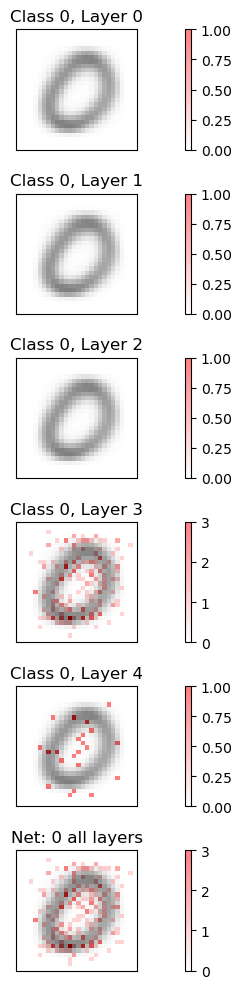

Used weights:  250


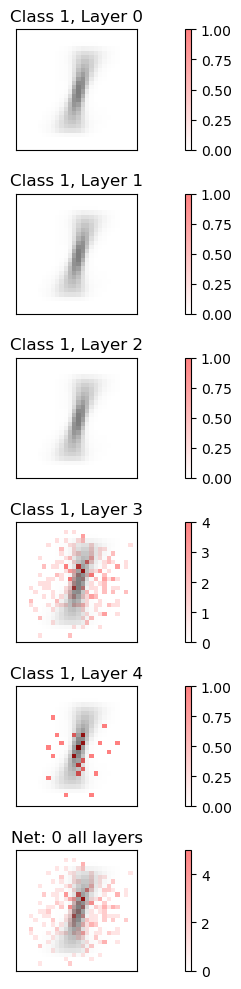

Used weights:  322


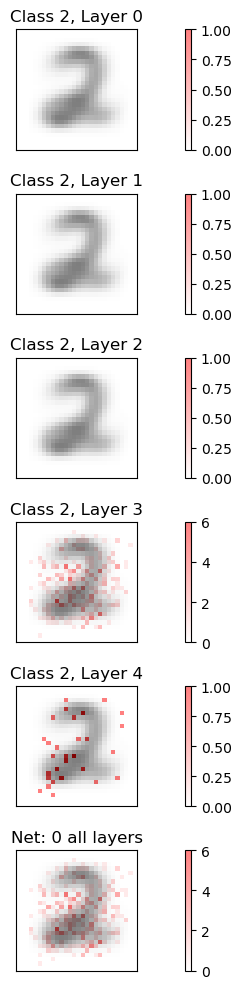

Used weights:  291


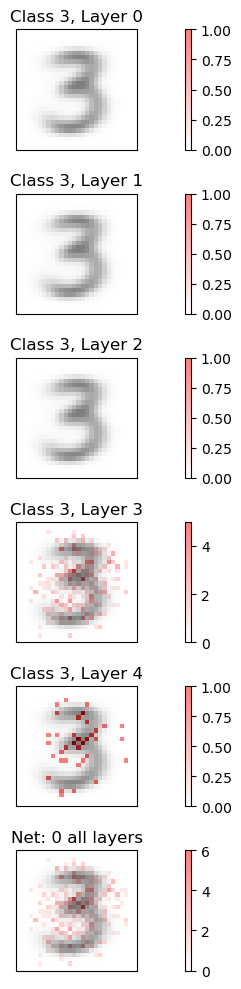

Used weights:  321


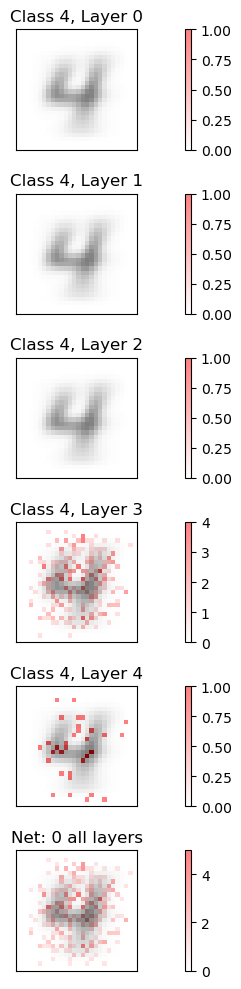

Used weights:  315


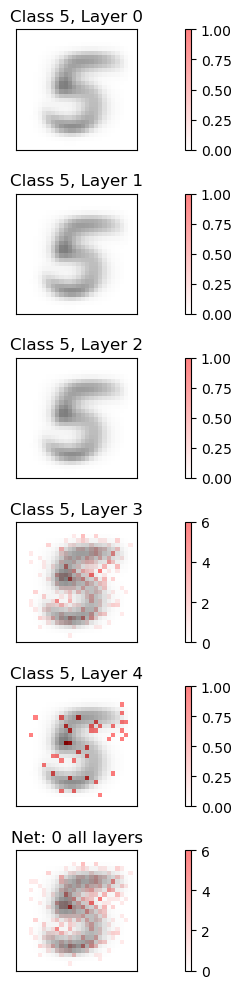

Used weights:  232


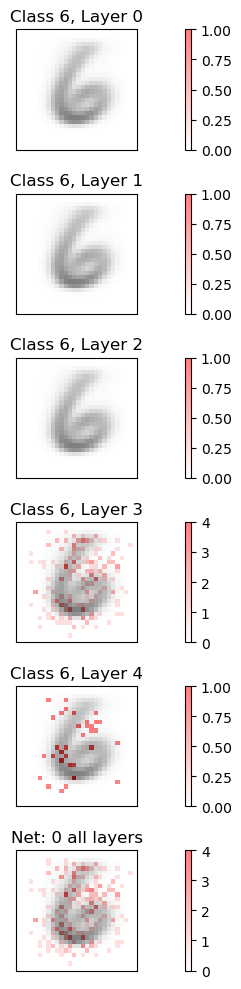

Used weights:  244


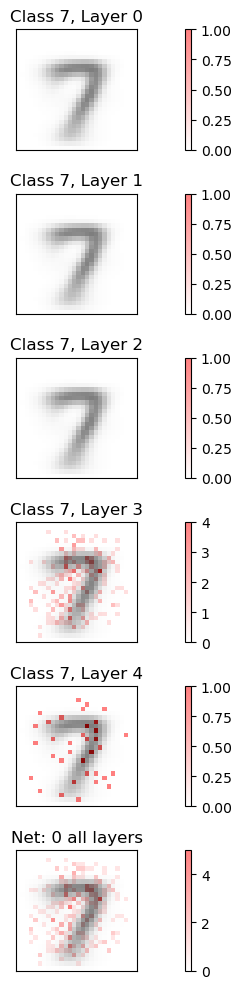

Used weights:  351


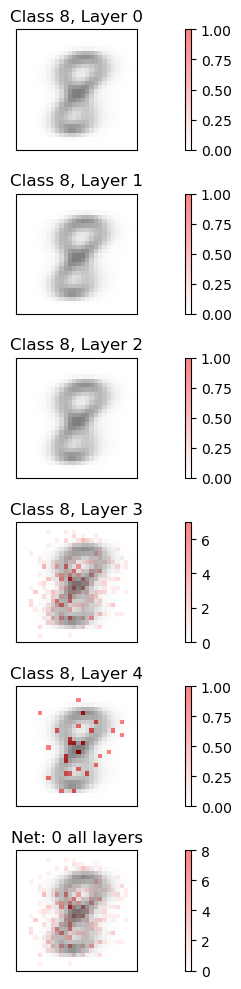

Used weights:  302


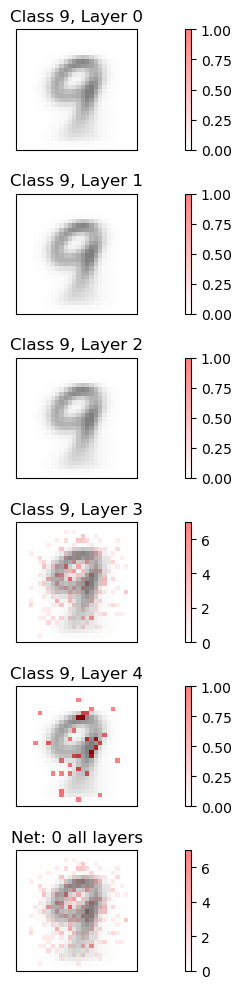

In [4]:
import torchvision
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=False, transform=transforms.ToTensor())

train_data = trainset.data/255.
train_target = trainset.targets

test_data = testset.data/255.
test_target = testset.targets


all_data = torch.cat((train_data, test_data), 0)
all_targets = torch.cat((train_target, test_target), 0)
# Minimum accepted weight value
tresh = .0

def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for c in range(10):
    img = np.zeros(p)
    img_pos = np.zeros(p)
    img_neg = np.zeros(p)
    for i in range(1):
        img_avg = np.zeros(p)
        net = torch.load(f"../../MNIST_flow/MNIST/net{0}_large_2500_bs", map_location=torch.device('cpu'))

        include_list = [True]*10
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        w = weight_matrices(net)[-1][c, -28*28:].detach().numpy()
        w = np.where(clean_a[-1][c,-28*28:].detach().numpy() == 1, w, 0)
        
        img_pos = np.where(w>0, 1, 0)
        img_neg = np.where(w<0, -1, 0)
        avg_c_img = train_data[train_target == c].mean(axis=0)

        fig, axs = plt.subplots(len(clean_a)+1, figsize=(10,10))
        
        for ind, ca in enumerate(clean_a):
            out = ca.shape[0]
            img_layer = np.zeros(p)
            for j in range(out):
                # img_layer += ca[j,-p:].detach().numpy()
                img_layer += np.where(np.abs(w) >= tresh, ca[j,-p:].detach().numpy(), 0)

            img_avg += img_layer
            axs[ind].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
            if np.sum(img_layer) > 0:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5)#, vmin=min_max*-1, vmax=min_max*1)
            else:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=1)
                
            fig.colorbar(im, ax=axs[ind])
            axs[ind].set_title(f"Class {c}, Layer {ind}")
            axs[ind].set_xticks([])
            axs[ind].set_yticks([])
            

        min_max = max(np.concatenate((img_pos, img_neg*-1)))
        min_max = max(np.concatenate((img_avg, img_avg*-1)))

        
        axs[ind+1].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
        im = axs[ind+1].imshow(img_avg.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=min_max*1)
        axs[ind+1].set_title(f"Net: {i} all layers")
        axs[ind+1].set_xticks([])
        axs[ind+1].set_yticks([])
        fig.colorbar(im, ax=axs[ind+1])
        plt.tight_layout()
        plt.show()

In [40]:
net.eval()
pred = net.forward(test_data, ensemble=False)

In [41]:
import copy
y = copy.deepcopy(test_target).detach().numpy()

In [42]:
class_pred = pred.max(1,keepdim=False)[1]
for i in range(CLASSES):
    print(f"Number: {i}:")
    include_list = [True]*CLASSES
    include_list[i] = False
    a = pip_func.get_alphas(net)
    a[-1][include_list,:] = 0
    clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
    print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))
    print(f"Acc: {np.sum(class_pred.detach().numpy()[y == i] == y[y==i])/len(y[y==i]):.4f}\n")

Number: 0:
Used weights:  209
Acc: 0.9857

Number: 1:
Used weights:  250
Acc: 0.9903

Number: 2:
Used weights:  322
Acc: 0.9593

Number: 3:
Used weights:  291
Acc: 0.9614

Number: 4:
Used weights:  321
Acc: 0.9532

Number: 5:
Used weights:  315
Acc: 0.9596

Number: 6:
Used weights:  232
Acc: 0.9666

Number: 7:
Used weights:  244
Acc: 0.9533

Number: 8:
Used weights:  351
Acc: 0.9517

Number: 9:
Used weights:  302
Acc: 0.9564



In [43]:
np.sum(class_pred.detach().numpy() == y)/len(y)

0.9641

## Back to results in thesis

In [2]:
for i in range(10):
    net = torch.load(f"../../MNIST_flow/MNIST/net{i}", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/flow_class/MNIST/net{i}")

### Smaller nets

In [2]:
import torchvision
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=False, transform=transforms.ToTensor())

train_data = trainset.data/255.
train_target = trainset.targets

test_data = testset.data/255.
test_target = testset.targets


all_data = torch.cat((train_data, test_data), 0)
all_targets = torch.cat((train_target, test_target), 0)

Used weights:  203


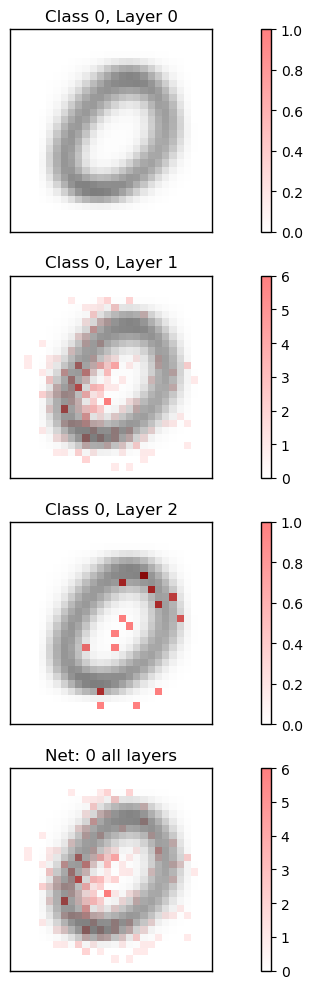

Used weights:  199


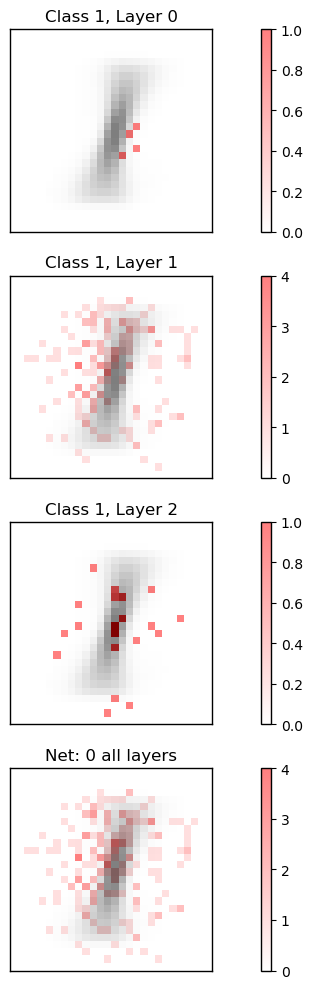

Used weights:  340


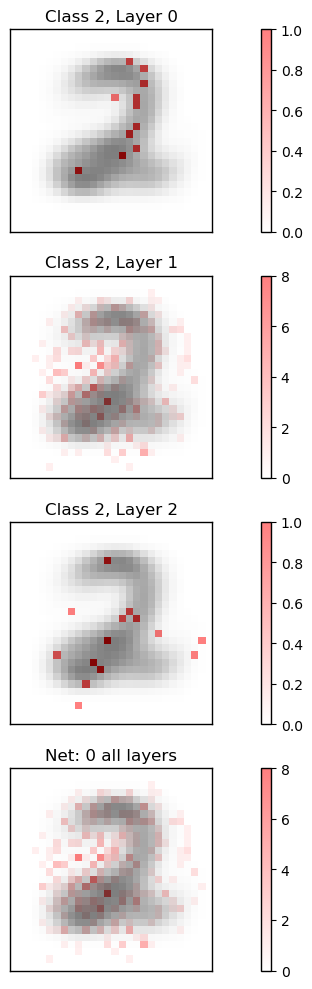

Used weights:  254


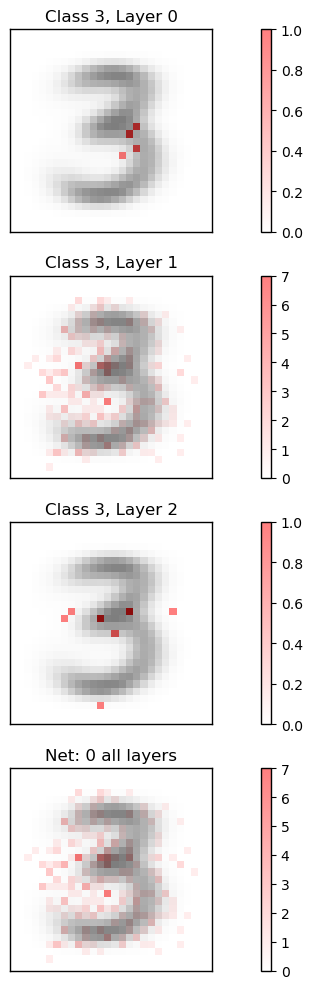

Used weights:  330


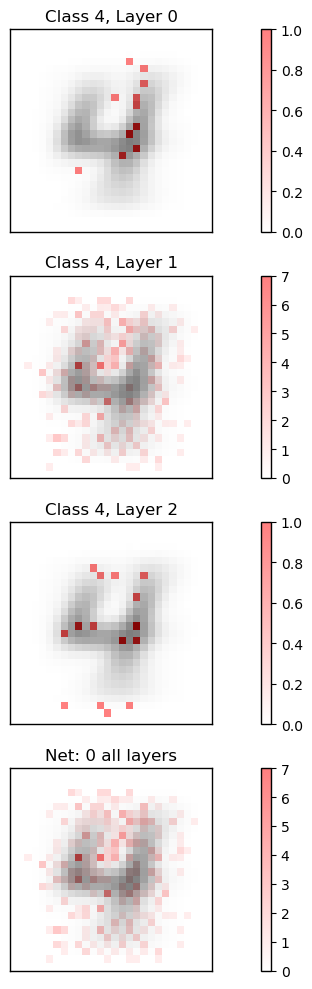

Used weights:  262


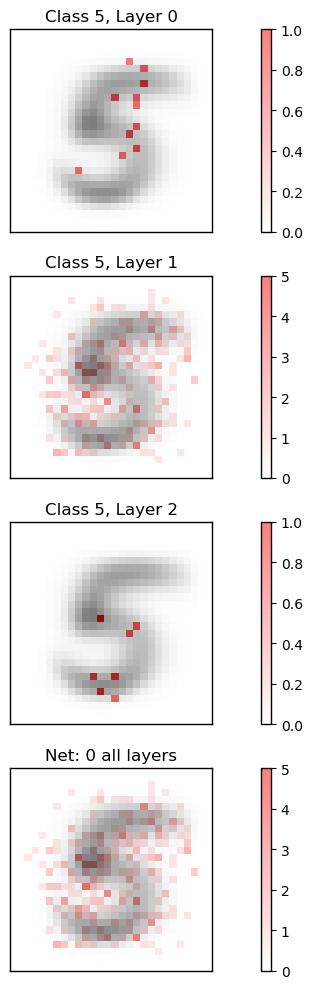

Used weights:  328


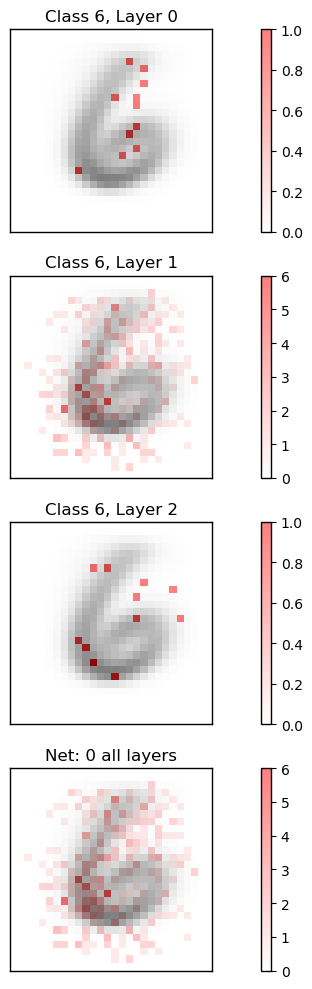

Used weights:  271


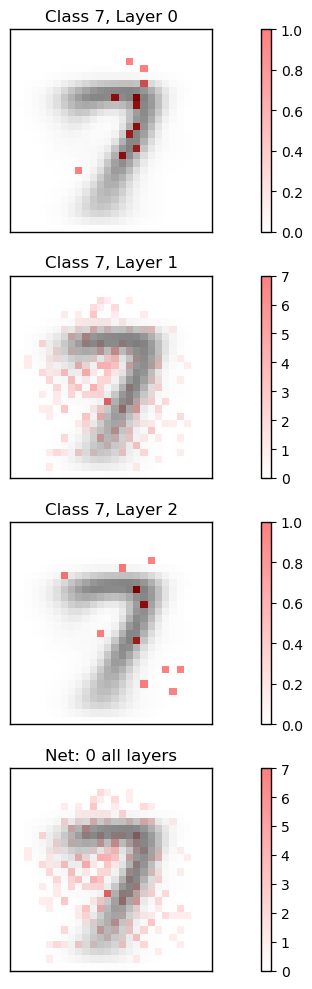

Used weights:  313


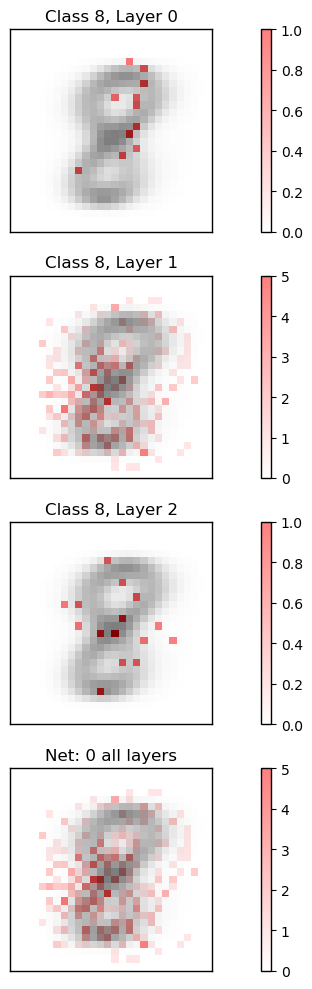

Used weights:  347


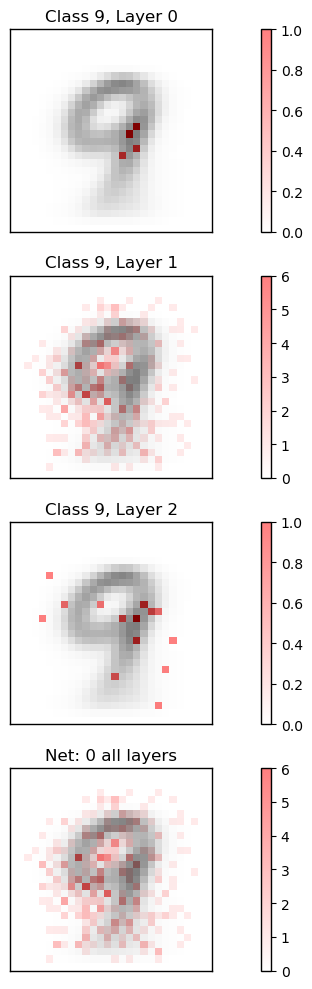

In [13]:
# Minimum accepted weight value
tresh = .0

def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for c in range(10):
    img = np.zeros(p)
    img_pos = np.zeros(p)
    img_neg = np.zeros(p)
    for i in range(1):
        img_avg = np.zeros(p)
        net = torch.load(f"../../MNIST_flow/MNIST/net{i}", map_location=torch.device('cpu'))

        include_list = [True]*10
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        w = weight_matrices(net)[-1][c, -28*28:].detach().numpy()
        w = np.where(clean_a[-1][c,-28*28:].detach().numpy() == 1, w, 0)
        
        img_pos = np.where(w>0, 1, 0)
        img_neg = np.where(w<0, -1, 0)
        avg_c_img = train_data[train_target == c].mean(axis=0)

        fig, axs = plt.subplots(len(clean_a)+1, figsize=(10,10))
        
        for ind, ca in enumerate(clean_a):
            out = ca.shape[0]
            img_layer = np.zeros(p)
            for j in range(out):
                # img_layer += ca[j,-p:].detach().numpy()
                img_layer += np.where(np.abs(w) >= tresh, ca[j,-p:].detach().numpy(), 0)

            img_avg += img_layer
            axs[ind].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
            if np.sum(img_layer) > 0:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5)#, vmin=min_max*-1, vmax=min_max*1)
            else:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=1)
                
            fig.colorbar(im, ax=axs[ind])
            axs[ind].set_title(f"Class {c}, Layer {ind}")
            axs[ind].set_xticks([])
            axs[ind].set_yticks([])
            

        min_max = max(np.concatenate((img_pos, img_neg*-1)))
        min_max = max(np.concatenate((img_avg, img_avg*-1)))

        
        axs[ind+1].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
        im = axs[ind+1].imshow(img_avg.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=min_max*1)
        axs[ind+1].set_title(f"Net: {i} all layers")
        axs[ind+1].set_xticks([])
        axs[ind+1].set_yticks([])
        fig.colorbar(im, ax=axs[ind+1])
        plt.tight_layout()
        plt.show()

## Acc and density

In [7]:
import numpy as np

res = {}
data = np.loadtxt(f"results/flow_class/MNIST/MNIST_KL_metrics_FLOW_2_hidden_600_dim_0.005_lr_2_num_trans.txt", delimiter=",")

res["median_acc_full"] = np.median(data, 0)[1]
res["min_acc_full"] = np.min(data, 0)[1]
res["max_acc_full"] = np.max(data, 0)[1]

res["median_acc_median"] = np.median(data, 0)[0]
res["min_acc_median"] = np.min(data, 0)[0]
res["max_acc_median"] = np.max(data, 0)[0]

res["median_density"] = np.median(data, 0)[2]
res["min_density"] = np.min(data, 0)[2]
res["max_density"] = np.max(data, 0)[2]

res["median_used_weights"] = np.median(data, 0)[3]
res["min_used_weights"] = np.min(data, 0)[3]
res["max_used_weights"] = np.max(data, 0)[3]

res

{'median_acc_full': 0.9697,
 'min_acc_full': 0.9688,
 'max_acc_full': 0.9709,
 'median_acc_median': 0.96885,
 'min_acc_median': 0.9679,
 'max_acc_median': 0.9702,
 'median_density': 0.0007074180175550282,
 'min_density': 0.0006678634672425687,
 'max_density': 0.0007287166081368923,
 'median_used_weights': 930.0,
 'min_used_weights': 878.0,
 'max_used_weights': 958.0}

## Used weights

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/MNIST/"
res = {}


res["used_weights"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 930.0
min: 878
max: 958



In [9]:
alphas = pip_func.get_alphas_numpy(net)
nr_weights = np.sum([np.prod(a.shape) for a in alphas])
print(f"Tot amount of weigths available: {nr_weights}")

Tot amount of weigths available: 1314640


## Depth and width

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/MNIST/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.8298510593664779
1.8036211699164346
1.848901098901099

Max depth
3.0
2
3



## Inclution rate

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/flow_class/MNIST/"
res = {}
rate_list = []
for i in range(p):
    res[f"x{i+1}_inclution_rate"] = 0
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
        #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
        count = 0
        for j in median_info["include_inputs"]:
            count += j[i]

        res[f"x{i+1}_inclution_rate"] += (count>0)
    res[f"x{i+1}_inclution_rate"] /= n_nets
    rate_list.append(res[f"x{i+1}_inclution_rate"])

res

{'x1_inclution_rate': 0.0,
 'x2_inclution_rate': 0.0,
 'x3_inclution_rate': 0.0,
 'x4_inclution_rate': 0.0,
 'x5_inclution_rate': 0.0,
 'x6_inclution_rate': 0.0,
 'x7_inclution_rate': 0.0,
 'x8_inclution_rate': 0.0,
 'x9_inclution_rate': 0.0,
 'x10_inclution_rate': 0.0,
 'x11_inclution_rate': 0.0,
 'x12_inclution_rate': 0.0,
 'x13_inclution_rate': 0.0,
 'x14_inclution_rate': 0.0,
 'x15_inclution_rate': 0.0,
 'x16_inclution_rate': 0.0,
 'x17_inclution_rate': 0.0,
 'x18_inclution_rate': 0.0,
 'x19_inclution_rate': 0.0,
 'x20_inclution_rate': 0.0,
 'x21_inclution_rate': 0.0,
 'x22_inclution_rate': 0.0,
 'x23_inclution_rate': 0.0,
 'x24_inclution_rate': 0.0,
 'x25_inclution_rate': 0.0,
 'x26_inclution_rate': 0.0,
 'x27_inclution_rate': 0.0,
 'x28_inclution_rate': 0.0,
 'x29_inclution_rate': 0.0,
 'x30_inclution_rate': 0.0,
 'x31_inclution_rate': 0.0,
 'x32_inclution_rate': 0.0,
 'x33_inclution_rate': 0.0,
 'x34_inclution_rate': 0.0,
 'x35_inclution_rate': 0.0,
 'x36_inclution_rate': 0.0,
 

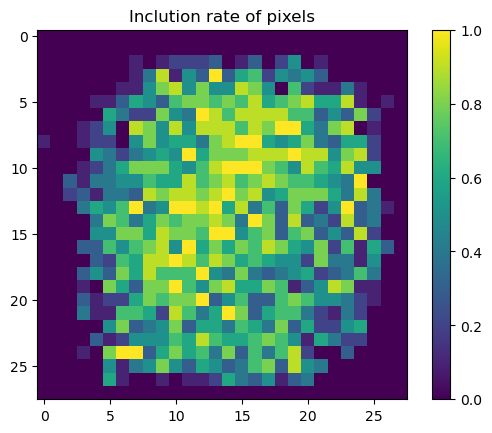

In [12]:
rate_list_numpy = np.array(rate_list)
rate_list_numpy = rate_list_numpy.reshape((28,28))

plt.imshow(rate_list_numpy)
plt.colorbar()
plt.title("Inclution rate of pixels")
plt.show()

In [1]:
import numpy as np
complexity_non_lin_func_flow  = np.load("complexity/flow_class/mnist/complexity_class.npy", allow_pickle=True).item()
dict_non_lin_flow = {}
for c in complexity_non_lin_func_flow[0].keys():
    lin_flow = []
    for k in complexity_non_lin_func_flow.keys():
        lin_flow.append(complexity_non_lin_func_flow[k][c])
    dict_non_lin_flow[c] = [np.median(lin_flow), np.min(lin_flow), np.max(lin_flow)]

dict_non_lin_flow

{0: [185197.3, 60699.57, 474675.22],
 1: [85826.81, 41009.67, 212000.06],
 2: [138415.83, 53295.04, 257835.22],
 3: [84060.16, 42698.71, 211834.25],
 4: [220337.55, 81025.45, 270036.6],
 5: [106605.625, 57649.082, 518963.1],
 6: [316526.62, 124797.51, 800780.94],
 7: [172403.69, 89739.69, 285477.2],
 8: [69980.59, 42428.707, 199175.36],
 9: [199904.62, 122829.36, 356786.78]}